#### In this notebook we explore the correlation coefficient between ensemble ARMA time series and the original FMRI time series.

In [1]:
import pingouin as pg
import pandas as pd
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import seaborn
import math

D:\anaconda\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Reading in Files

In [2]:
# Reading in Rscore files by stack and concatenate them
runs = ['run1','run2','run3','run4']
all_Rscore = []

for run in runs:
    file = 'E:/projects/connectome/results/'+run+'/Rscore/Rscore_1.csv'
    Rscore = pd.read_csv(file)
    Rscore = Rscore.rename(columns={'Unnamed: 0':'ID'})
    Rscore = Rscore.set_index('ID')
    for i in range(2,21):
        file = 'E:/projects/connectome/results/'+run+'/Rscore/Rscore_'+str(i)+'.csv'
        tmp2 = pd.read_csv(file)
        tmp2 = tmp2.rename(columns={'Unnamed: 0':'ID'})
        tmp2 = tmp2.set_index('ID')
        Rscore = pd.concat([Rscore, tmp2],sort=True)

    # sort regions by region number
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:int(reg.strip('region '))})
    Rscore = Rscore.sort_index(axis=1)
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:'region '+str(reg)})
    
    # sort by subject ID and save to file
    Rscore.to_csv('E:/projects/connectome/results/'+run+'/Rscore/Rscore_all.csv',index=True)
    
    all_Rscore.append(Rscore)

In [3]:
for i in range(4):
    all_Rscore[i] = all_Rscore[i].sort_index()
    all_Rscore[i].index = list(range(1,len(all_Rscore[i].index)+1))
    all_Rscore[i].columns = list(range(1,len(all_Rscore[i].columns)+1))

Visualize with heatmap

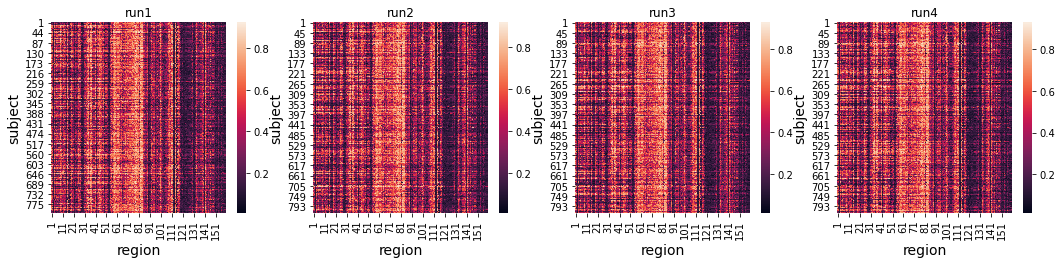

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 3.5))
for i in range(4):
    seaborn.heatmap(all_Rscore[i],ax=axes[i])
    axes[i].set_title('run'+str(i+1))
    axes[i].set_xlabel('region',fontsize=14)
    axes[i].set_ylabel('subject',fontsize=14)
plt.show()

# Performing Significance Tests

#### Since some regions negative correlations, even though there is only a small number of those, we want to see if the mean of each regions are still significant. Once this is established, we set out to use the absolute correlation. 

In [5]:
for j in range(4):
    ttests = [] # whether the mean of correlations of each region is siginificant from zero
    for i in range(1,161):
        reg = i
        ttests.append(scipy.stats.ttest_1samp(all_Rscore[j][reg],0))
    
    ttest_significant = []
    for ttest in ttests:
        ttest_significant.append(ttest[1]<0.01)
    print("By T-tests, the number of significant regions in run{} is: {}".format(j+1,sum(ttest_significant)))

By T-tests, the number of significant regions in run1 is: 160
By T-tests, the number of significant regions in run2 is: 160
By T-tests, the number of significant regions in run3 is: 160
By T-tests, the number of significant regions in run4 is: 160


In [6]:
for j in range(4):
    wtests = [] # whether the mean of correlations of each region is siginificant from zero
    for i in range(1,161):
        reg = i
        wtests.append(scipy.stats.wilcoxon(all_Rscore[j][reg]))
    
    wtest_significant = []
    for wtest in wtests:
        wtest_significant.append(wtest[1]<0.01)
    print("By Wilcoxon tests, the number of significant regions in run{} is: {}".format(j+1,sum(wtest_significant)))

By Wilcoxon tests, the number of significant regions in run1 is: 160
By Wilcoxon tests, the number of significant regions in run2 is: 160
By Wilcoxon tests, the number of significant regions in run3 is: 160
By Wilcoxon tests, the number of significant regions in run4 is: 160


# Compute Average Correlation

#### We will utilize seven different variance stabilizing transformations to facilitate the computation of average correlations. Brute force arithmetic averaging would not make much sense statistically. The easiet example of arithmetically averaging correlations to produce non-sensical result is r1=0.5 and r2=-0.5. In fact, since correlations are not normally distributed, we cannot take arithmetic average. By using stabilizing transformations, we wish to make the distribution of our correlations closer to normal (yet still not quite as indicated by the normality test). At least, now  the averages obtained would not sound as absurd. 

In [7]:
# Ideas of the following VST's: (1) transform data (2)compute average for the transformed data (3)inverse-transform the average
def fisherAvg(corrs):
    z = 0.5*np.log((1+corrs)/(1-corrs))
    avg_z = sum(z)/len(corrs)
    return (math.exp(2*avg_z) - 1) / (math.exp(2*avg_z) + 1)

def squareAvg(corrs):
    return math.sqrt(sum(corrs**2)/len(corrs))

def rootAvg(corrs):
    return (sum(corrs**0.5)/len(corrs))**2

def arccosAvg(corrs):
    return np.cos(sum(np.arccos(corrs))/len(corrs))

def harmonicAvg(corrs):
    return 1/(sum(1/np.arcsin(corrs))/len(corrs))

def geomAvg(corrs):
    return np.exp(sum(np.log(corrs))/len(corrs))

def arsinhAvg(corrs):
    return np.sum(np.log(corrs+(corrs**2+1)**0.5))/len(corrs)

#### These three averaging methods only work for positive correlations

In [8]:
averages = []

for j in range(4):
    fisher_avg = []
    square_avg = []
    root_avg = []
    arccos_avg = []
    geom_avg = []
    harmonic_avg = []
    arsinh_avg = []
    for i in range(1,161):
        reg = i
        fisher_avg.append(fisherAvg(all_Rscore[j][reg]))
        square_avg.append(squareAvg(all_Rscore[j][reg]))
        root_avg.append(rootAvg(all_Rscore[j][reg]))
        arccos_avg.append(arccosAvg(all_Rscore[j][reg]))
        harmonic_avg.append(harmonicAvg(all_Rscore[j][reg]))
        geom_avg.append(geomAvg(all_Rscore[j][reg]))
        arsinh_avg.append(arsinhAvg(all_Rscore[j][reg]))
    avg_corr_dict = {}
    for i in range(1,160):
        reg = i
        avg_corr_dict[reg] = [square_avg[i]]
    square_avg = pd.DataFrame(avg_corr_dict,index=['square'])

    avg_corr_dict = {}
    for i in range(1,160):
        reg = i
        avg_corr_dict[reg] = [root_avg[i]]
    root_avg = pd.DataFrame(avg_corr_dict,index=['root'])

    avg_corr_dict = {}
    for i in range(1,160):
        reg = i
        avg_corr_dict[reg] = [geom_avg[i]]
    geom_avg = pd.DataFrame(avg_corr_dict,index=['geom'])
    
    avg_corr_dict = {}
    for i in range(1,160):
        reg = i
        avg_corr_dict[reg] = [fisher_avg[i]]
    fisher_avg = pd.DataFrame(avg_corr_dict,index=['fisher'])

    avg_corr_dict = {}
    for i in range(1,160):
        reg = i
        avg_corr_dict[reg] = [arccos_avg[i]]
    arccos_avg = pd.DataFrame(avg_corr_dict,index=['arccos'])


    avg_corr_dict = {}
    for i in range(1,160):
        reg = i
        avg_corr_dict[reg] = [arsinh_avg[i]]
    arsinh_avg = pd.DataFrame(avg_corr_dict,index=['arsinh'])
    
    averages.append(pd.concat([fisher_avg,arccos_avg,arsinh_avg,geom_avg,square_avg,root_avg],axis=0))


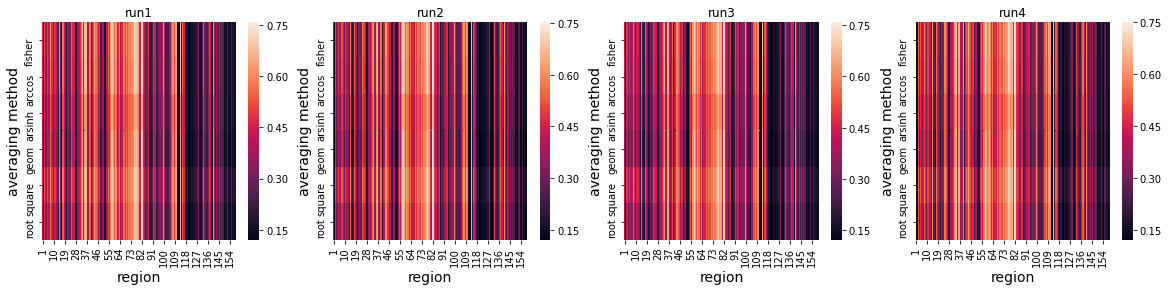

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
for i in range(4):
    seaborn.heatmap(averages[i],ax=axes[i])
    axes[i].title.set_text('run'+str(i+1))
    axes[i].set_xlabel('region',fontsize=14)
    axes[i].set_ylabel('averaging method',fontsize=14)
plt.show()

# Extract the Regions with the Highest Correlations

In [10]:
top_n = 15 # top 10 regions with the highest correlations to the original time-series
col_names = ['top '+str(i+1) for i in range(top_n)] 
top_n_regions = pd.DataFrame(columns=col_names) # get the most correlated regions out based on each averaging methods

In [11]:
averages[1]

,1,2,3,4,5,6,7,8,9,10,...,150,151,152,153,154,155,156,157,158,159
fisher,0.390228,0.129839,0.509327,0.325903,0.487945,0.382559,0.374928,0.528593,0.433918,0.307436,...,0.134476,0.166466,0.144127,0.270861,0.150969,0.131683,0.241024,0.156993,0.157541,0.147093
arccos,0.383054,0.129688,0.499096,0.318956,0.474285,0.373946,0.366521,0.514548,0.424208,0.302890,...,0.134196,0.165966,0.143870,0.269146,0.150647,0.131486,0.239182,0.156622,0.157099,0.146670
arsinh,0.364154,0.129045,0.467034,0.303822,0.440454,0.353944,0.346941,0.476542,0.399164,0.291573,...,0.133284,0.164307,0.142900,0.263101,0.149493,0.130742,0.233852,0.155311,0.155650,0.145393
geom,0.341057,0.122843,0.455688,0.270586,0.413886,0.325188,0.314355,0.459501,0.373519,0.264075,...,0.124767,0.152823,0.134998,0.246981,0.140400,0.123274,0.213785,0.146257,0.144850,0.135524
square,0.408756,0.136520,0.517156,0.354115,0.500902,0.404216,0.399095,0.535526,0.451135,0.331584,...,0.144696,0.179087,0.153153,0.286249,0.160971,0.139970,0.261015,0.167577,0.169938,0.159301
root,0.359079,0.126207,0.473453,0.291464,0.438910,0.345957,0.336955,0.481630,0.395052,0.281469,...,0.129213,0.159055,0.139220,0.257514,0.145331,0.127245,0.225538,0.151115,0.150597,0.140686


In [25]:
top_n_regions_for_run = []
for k in range(4): # k=0,1,2,3 denotes the index for each runs
    avg_methods = ['arccos','fisher','arsinh','geom','square','root']

    top_n_regions = []
    for j,avg_method in enumerate(avg_methods):
        tmp = {}
        # use double brackets [[]] in .loc to extract a row/columns in the form of dataframe;
        # otherwise, if used only single bracket [], that row would be extracted a series a lose index/column names 
        sorted_avg = averages[k].loc[[avg_method]].T.sort_values(by=avg_method,ascending=False)[:top_n].T
        cols = sorted_avg.columns
        for i,col in enumerate(cols):
            # to create a dataframe with tuple entries, wrap the tuples in a list
            # so dict[key]=[(tuple)] then create dataframe from dict pd.DataFrame(dict) 
            tmp['top '+str(i+1)]=[('region '+str(col),'avg_corr='+str(round(sorted_avg[col].values[0],2)))] # round the correlation to 3 decimal digits
        tmp = pd.DataFrame(tmp,index=[avg_method])
        top_n_regions.append(tmp)
        
    top_n_regions = pd.concat(top_n_regions,axis=0)
    top_n_regions_for_run.append(top_n_regions)

In [26]:
top_n_regions_for_run[0]

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10,top 11,top 12,top 13,top 14,top 15
arccos,"(region 82, avg_corr=0.75)","(region 58, avg_corr=0.71)","(region 83, avg_corr=0.71)","(region 78, avg_corr=0.71)","(region 77, avg_corr=0.7)","(region 37, avg_corr=0.67)","(region 114, avg_corr=0.67)","(region 36, avg_corr=0.66)","(region 34, avg_corr=0.66)","(region 80, avg_corr=0.65)","(region 61, avg_corr=0.65)","(region 110, avg_corr=0.64)","(region 111, avg_corr=0.64)","(region 59, avg_corr=0.64)","(region 79, avg_corr=0.64)"
fisher,"(region 82, avg_corr=0.76)","(region 83, avg_corr=0.72)","(region 58, avg_corr=0.72)","(region 78, avg_corr=0.72)","(region 77, avg_corr=0.71)","(region 37, avg_corr=0.68)","(region 36, avg_corr=0.68)","(region 114, avg_corr=0.67)","(region 34, avg_corr=0.67)","(region 80, avg_corr=0.66)","(region 110, avg_corr=0.66)","(region 61, avg_corr=0.65)","(region 111, avg_corr=0.65)","(region 59, avg_corr=0.65)","(region 44, avg_corr=0.65)"
arsinh,"(region 82, avg_corr=0.69)","(region 58, avg_corr=0.66)","(region 83, avg_corr=0.66)","(region 78, avg_corr=0.65)","(region 77, avg_corr=0.64)","(region 114, avg_corr=0.62)","(region 37, avg_corr=0.62)","(region 36, avg_corr=0.61)","(region 80, avg_corr=0.61)","(region 34, avg_corr=0.6)","(region 61, avg_corr=0.6)","(region 59, avg_corr=0.59)","(region 110, avg_corr=0.59)","(region 111, avg_corr=0.59)","(region 79, avg_corr=0.59)"
geom,"(region 82, avg_corr=0.74)","(region 58, avg_corr=0.7)","(region 83, avg_corr=0.7)","(region 78, avg_corr=0.69)","(region 77, avg_corr=0.67)","(region 114, avg_corr=0.65)","(region 37, avg_corr=0.64)","(region 36, avg_corr=0.63)","(region 80, avg_corr=0.63)","(region 61, avg_corr=0.63)","(region 34, avg_corr=0.62)","(region 59, avg_corr=0.62)","(region 79, avg_corr=0.62)","(region 111, avg_corr=0.61)","(region 110, avg_corr=0.61)"
square,"(region 82, avg_corr=0.75)","(region 58, avg_corr=0.71)","(region 83, avg_corr=0.71)","(region 78, avg_corr=0.71)","(region 77, avg_corr=0.7)","(region 37, avg_corr=0.67)","(region 36, avg_corr=0.67)","(region 114, avg_corr=0.67)","(region 34, avg_corr=0.66)","(region 80, avg_corr=0.66)","(region 110, avg_corr=0.65)","(region 61, avg_corr=0.65)","(region 111, avg_corr=0.65)","(region 59, avg_corr=0.65)","(region 79, avg_corr=0.64)"
root,"(region 82, avg_corr=0.75)","(region 58, avg_corr=0.7)","(region 83, avg_corr=0.7)","(region 78, avg_corr=0.69)","(region 77, avg_corr=0.68)","(region 114, avg_corr=0.65)","(region 37, avg_corr=0.65)","(region 36, avg_corr=0.64)","(region 80, avg_corr=0.64)","(region 61, avg_corr=0.63)","(region 34, avg_corr=0.63)","(region 59, avg_corr=0.63)","(region 79, avg_corr=0.62)","(region 111, avg_corr=0.62)","(region 110, avg_corr=0.62)"


In [27]:
top_n_regions_for_run[1]

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10,top 11,top 12,top 13,top 14,top 15
arccos,"(region 82, avg_corr=0.75)","(region 83, avg_corr=0.71)","(region 78, avg_corr=0.71)","(region 58, avg_corr=0.71)","(region 77, avg_corr=0.67)","(region 80, avg_corr=0.66)","(region 114, avg_corr=0.66)","(region 59, avg_corr=0.66)","(region 34, avg_corr=0.65)","(region 37, avg_corr=0.64)","(region 79, avg_corr=0.64)","(region 73, avg_corr=0.64)","(region 36, avg_corr=0.63)","(region 61, avg_corr=0.63)","(region 76, avg_corr=0.61)"
fisher,"(region 82, avg_corr=0.75)","(region 83, avg_corr=0.72)","(region 78, avg_corr=0.72)","(region 58, avg_corr=0.72)","(region 77, avg_corr=0.68)","(region 80, avg_corr=0.67)","(region 114, avg_corr=0.67)","(region 59, avg_corr=0.66)","(region 34, avg_corr=0.66)","(region 37, avg_corr=0.65)","(region 79, avg_corr=0.65)","(region 73, avg_corr=0.64)","(region 36, avg_corr=0.64)","(region 61, avg_corr=0.63)","(region 76, avg_corr=0.62)"
arsinh,"(region 82, avg_corr=0.68)","(region 83, avg_corr=0.65)","(region 58, avg_corr=0.65)","(region 78, avg_corr=0.65)","(region 77, avg_corr=0.62)","(region 80, avg_corr=0.61)","(region 114, avg_corr=0.61)","(region 59, avg_corr=0.61)","(region 34, avg_corr=0.6)","(region 79, avg_corr=0.59)","(region 73, avg_corr=0.59)","(region 37, avg_corr=0.59)","(region 61, avg_corr=0.58)","(region 36, avg_corr=0.58)","(region 76, avg_corr=0.57)"
geom,"(region 82, avg_corr=0.74)","(region 83, avg_corr=0.7)","(region 58, avg_corr=0.69)","(region 78, avg_corr=0.69)","(region 80, avg_corr=0.64)","(region 77, avg_corr=0.64)","(region 114, avg_corr=0.64)","(region 59, avg_corr=0.63)","(region 73, avg_corr=0.62)","(region 79, avg_corr=0.62)","(region 34, avg_corr=0.61)","(region 37, avg_corr=0.61)","(region 61, avg_corr=0.61)","(region 36, avg_corr=0.6)","(region 76, avg_corr=0.59)"
square,"(region 82, avg_corr=0.75)","(region 83, avg_corr=0.71)","(region 78, avg_corr=0.71)","(region 58, avg_corr=0.71)","(region 77, avg_corr=0.68)","(region 80, avg_corr=0.66)","(region 114, avg_corr=0.66)","(region 59, avg_corr=0.66)","(region 34, avg_corr=0.66)","(region 37, avg_corr=0.65)","(region 79, avg_corr=0.64)","(region 73, avg_corr=0.64)","(region 36, avg_corr=0.64)","(region 61, avg_corr=0.63)","(region 76, avg_corr=0.62)"
root,"(region 82, avg_corr=0.74)","(region 83, avg_corr=0.7)","(region 58, avg_corr=0.7)","(region 78, avg_corr=0.7)","(region 77, avg_corr=0.65)","(region 80, avg_corr=0.65)","(region 114, avg_corr=0.65)","(region 59, avg_corr=0.64)","(region 34, avg_corr=0.63)","(region 79, avg_corr=0.62)","(region 73, avg_corr=0.62)","(region 37, avg_corr=0.62)","(region 61, avg_corr=0.61)","(region 36, avg_corr=0.61)","(region 76, avg_corr=0.6)"


In [28]:
top_n_regions_for_run[2]

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10,top 11,top 12,top 13,top 14,top 15
arccos,"(region 82, avg_corr=0.75)","(region 83, avg_corr=0.71)","(region 58, avg_corr=0.71)","(region 78, avg_corr=0.71)","(region 77, avg_corr=0.68)","(region 114, avg_corr=0.67)","(region 37, avg_corr=0.65)","(region 80, avg_corr=0.65)","(region 61, avg_corr=0.65)","(region 36, avg_corr=0.65)","(region 34, avg_corr=0.65)","(region 79, avg_corr=0.64)","(region 59, avg_corr=0.64)","(region 74, avg_corr=0.63)","(region 76, avg_corr=0.63)"
fisher,"(region 82, avg_corr=0.76)","(region 83, avg_corr=0.72)","(region 58, avg_corr=0.72)","(region 78, avg_corr=0.71)","(region 77, avg_corr=0.69)","(region 114, avg_corr=0.67)","(region 37, avg_corr=0.67)","(region 80, avg_corr=0.66)","(region 36, avg_corr=0.66)","(region 34, avg_corr=0.66)","(region 61, avg_corr=0.66)","(region 79, avg_corr=0.65)","(region 59, avg_corr=0.65)","(region 74, avg_corr=0.64)","(region 76, avg_corr=0.64)"
arsinh,"(region 82, avg_corr=0.69)","(region 83, avg_corr=0.66)","(region 58, avg_corr=0.65)","(region 78, avg_corr=0.65)","(region 77, avg_corr=0.62)","(region 114, avg_corr=0.62)","(region 80, avg_corr=0.6)","(region 37, avg_corr=0.6)","(region 61, avg_corr=0.6)","(region 36, avg_corr=0.6)","(region 34, avg_corr=0.59)","(region 79, avg_corr=0.59)","(region 59, avg_corr=0.59)","(region 74, avg_corr=0.59)","(region 76, avg_corr=0.58)"
geom,"(region 82, avg_corr=0.74)","(region 83, avg_corr=0.7)","(region 58, avg_corr=0.69)","(region 78, avg_corr=0.69)","(region 114, avg_corr=0.65)","(region 77, avg_corr=0.64)","(region 80, avg_corr=0.63)","(region 61, avg_corr=0.63)","(region 37, avg_corr=0.62)","(region 79, avg_corr=0.62)","(region 36, avg_corr=0.62)","(region 59, avg_corr=0.61)","(region 34, avg_corr=0.61)","(region 74, avg_corr=0.61)","(region 76, avg_corr=0.61)"
square,"(region 82, avg_corr=0.75)","(region 83, avg_corr=0.71)","(region 58, avg_corr=0.71)","(region 78, avg_corr=0.71)","(region 77, avg_corr=0.68)","(region 114, avg_corr=0.67)","(region 37, avg_corr=0.66)","(region 80, avg_corr=0.66)","(region 36, avg_corr=0.65)","(region 34, avg_corr=0.65)","(region 61, avg_corr=0.65)","(region 79, avg_corr=0.64)","(region 59, avg_corr=0.64)","(region 74, avg_corr=0.64)","(region 76, avg_corr=0.63)"
root,"(region 82, avg_corr=0.75)","(region 83, avg_corr=0.7)","(region 58, avg_corr=0.7)","(region 78, avg_corr=0.69)","(region 77, avg_corr=0.66)","(region 114, avg_corr=0.65)","(region 80, avg_corr=0.64)","(region 61, avg_corr=0.64)","(region 37, avg_corr=0.63)","(region 36, avg_corr=0.63)","(region 79, avg_corr=0.62)","(region 34, avg_corr=0.62)","(region 59, avg_corr=0.62)","(region 74, avg_corr=0.62)","(region 76, avg_corr=0.61)"


In [29]:
top_n_regions_for_run[3]

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10,top 11,top 12,top 13,top 14,top 15
arccos,"(region 82, avg_corr=0.74)","(region 83, avg_corr=0.72)","(region 78, avg_corr=0.71)","(region 58, avg_corr=0.71)","(region 77, avg_corr=0.71)","(region 34, avg_corr=0.68)","(region 80, avg_corr=0.67)","(region 114, avg_corr=0.67)","(region 59, avg_corr=0.66)","(region 37, avg_corr=0.65)","(region 36, avg_corr=0.65)","(region 73, avg_corr=0.65)","(region 79, avg_corr=0.64)","(region 44, avg_corr=0.64)","(region 61, avg_corr=0.63)"
fisher,"(region 82, avg_corr=0.75)","(region 83, avg_corr=0.73)","(region 78, avg_corr=0.72)","(region 77, avg_corr=0.72)","(region 58, avg_corr=0.72)","(region 34, avg_corr=0.69)","(region 80, avg_corr=0.68)","(region 114, avg_corr=0.67)","(region 59, avg_corr=0.67)","(region 36, avg_corr=0.66)","(region 37, avg_corr=0.66)","(region 73, avg_corr=0.65)","(region 44, avg_corr=0.65)","(region 79, avg_corr=0.65)","(region 110, avg_corr=0.64)"
arsinh,"(region 82, avg_corr=0.68)","(region 83, avg_corr=0.66)","(region 78, avg_corr=0.66)","(region 58, avg_corr=0.65)","(region 77, avg_corr=0.64)","(region 34, avg_corr=0.62)","(region 114, avg_corr=0.62)","(region 80, avg_corr=0.62)","(region 59, avg_corr=0.61)","(region 73, avg_corr=0.6)","(region 37, avg_corr=0.6)","(region 36, avg_corr=0.6)","(region 79, avg_corr=0.6)","(region 44, avg_corr=0.59)","(region 61, avg_corr=0.59)"
geom,"(region 82, avg_corr=0.73)","(region 83, avg_corr=0.7)","(region 78, avg_corr=0.7)","(region 58, avg_corr=0.69)","(region 77, avg_corr=0.67)","(region 114, avg_corr=0.65)","(region 80, avg_corr=0.65)","(region 34, avg_corr=0.64)","(region 59, avg_corr=0.64)","(region 73, avg_corr=0.63)","(region 79, avg_corr=0.62)","(region 36, avg_corr=0.62)","(region 37, avg_corr=0.62)","(region 61, avg_corr=0.61)","(region 44, avg_corr=0.61)"
square,"(region 82, avg_corr=0.74)","(region 83, avg_corr=0.72)","(region 78, avg_corr=0.71)","(region 58, avg_corr=0.71)","(region 77, avg_corr=0.71)","(region 34, avg_corr=0.68)","(region 80, avg_corr=0.67)","(region 114, avg_corr=0.67)","(region 59, avg_corr=0.66)","(region 37, avg_corr=0.66)","(region 36, avg_corr=0.66)","(region 73, avg_corr=0.65)","(region 44, avg_corr=0.65)","(region 79, avg_corr=0.65)","(region 61, avg_corr=0.64)"
root,"(region 82, avg_corr=0.74)","(region 83, avg_corr=0.71)","(region 78, avg_corr=0.7)","(region 58, avg_corr=0.7)","(region 77, avg_corr=0.68)","(region 114, avg_corr=0.65)","(region 34, avg_corr=0.65)","(region 80, avg_corr=0.65)","(region 59, avg_corr=0.64)","(region 73, avg_corr=0.64)","(region 37, avg_corr=0.63)","(region 36, avg_corr=0.63)","(region 79, avg_corr=0.63)","(region 44, avg_corr=0.62)","(region 61, avg_corr=0.62)"


# Variance of Correlations

In [30]:
variance = [] # variance of the correlations of each region
for i in range(1,161):
    reg = 'region '+str(i)
    variance.append(np.var(Rscore[reg]))

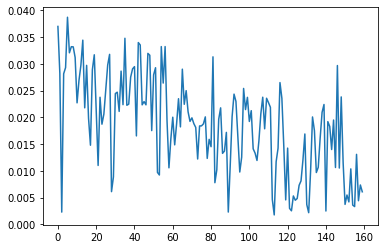

In [31]:
plt.plot(variance)
plt.show()

# Plotting the Ensemble Time-series on top of the Original

In [19]:
def plotTS(sub,reg,start,end):
    # sub: subject ID
    # reg: region number
    # start, end: starting point and end point of the time-series that is to be plotted
    fitted_file = 'E:/projects/connectome/results/run3/ensemble_ts/ensemble_ts_'+str(sub)+'.mat'
    fitted_matrix = scipy.io.loadmat(fitted_file)
    fitted_ts = fitted_matrix['ensemble_ts'][reg-1][start:end]
    original_file = 'E:/projects/connectome/data/FMRI_820subs/run2/DOS160_TC_HCP_REST1RL_'+str(sub)+'.mat'
    original_matrix = scipy.io.loadmat(original_file)
    original_ts = original_matrix['tc'][:,reg-1][start:end]
    plt.plot(fitted_ts, color='g',label='fitted_ensemble')
    plt.plot(original_ts, color='r', label='original' )
    plt.legend()
    plt.show()

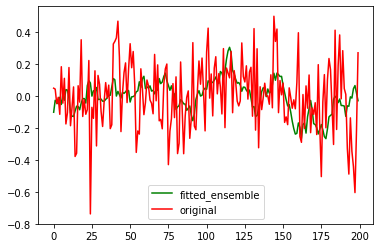

In [20]:
plotTS(173940,100,400,600)